In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from io import StringIO
from sklearn.linear_model import Lasso, LogisticRegression, RidgeClassifier
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import tree

import os
os.environ["PATH"] += os.pathsep + 'D:/graphviz/Graphviz/bin'

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import graphviz

from IPython.display import display, HTML
from collections import *
warnings.filterwarnings('ignore')

## Partie d'exploitation de données

1. **Prepare data**

In [2]:
data = pd.read_csv('Axe 1/output/clients_manages_tabular_time_series_v3.csv')
data.head()

,id_client,date,mnt_ttc_echeance_std,mnt_solde_charges_ccl_std,mnt_ttc_facture_ccl_std,mnt_sls_ccl_std,mnt_aides_ccl_std,mnt_total_encaisse_std,solde_std,nb_couple_av_enf_std,...,geo_localite,terme_lib,age_std_x,type_trf_lib,elo_categ_financement_inii,cnc_tem_apl,cnc_tem_al,cnc_tem_sls,mnt_caution_dg_ccl_std,cnc_dtdval
0,0,20180131,528.85,0.0,528.85,0.0,0.0,530.0,-81.18,1.0,...,-1,TERME ECHU,50.0,Relocation,PLC,0.0,0.0,0.0,0.0,2018-01-31
1,0,20180228,528.85,0.0,528.85,0.0,0.0,530.0,-82.33,1.0,...,-1,TERME ECHU,50.0,Relocation,PLC,0.0,0.0,0.0,0.0,2018-01-31
2,0,20180331,528.85,0.0,528.85,0.0,0.0,530.0,-83.48,1.0,...,-1,TERME ECHU,50.0,Relocation,PLC,0.0,0.0,0.0,0.0,2018-01-31
3,0,20180430,528.85,0.0,528.85,0.0,0.0,530.0,-84.63,1.0,...,-1,TERME ECHU,50.0,Relocation,PLC,0.0,0.0,0.0,0.0,2018-01-31
4,0,20180531,528.85,0.0,528.85,0.0,0.0,530.0,-85.78,1.0,...,-1,TERME ECHU,50.0,Relocation,PLC,0.0,0.0,0.0,0.0,2018-01-31


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334695 entries, 0 to 334694
Data columns (total 46 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id_client                   334695 non-null  int64  
 1   date                        334695 non-null  int64  
 2   mnt_ttc_echeance_std        334695 non-null  float64
 3   mnt_solde_charges_ccl_std   334695 non-null  float64
 4   mnt_ttc_facture_ccl_std     334695 non-null  float64
 5   mnt_sls_ccl_std             334695 non-null  float64
 6   mnt_aides_ccl_std           334695 non-null  float64
 7   mnt_total_encaisse_std      334695 non-null  float64
 8   solde_std                   334695 non-null  float64
 9   nb_couple_av_enf_std        334695 non-null  float64
 10  nb_divorce_std              334695 non-null  float64
 11  nb_monoparental_std         334695 non-null  float64
 12  nb_veuf_std                 334695 non-null  float64
 13  nb_celibataire

In [4]:
data2 = data[[column for column in data if data[column].count() / len(data) >= 0.3]]
print("List of dropped columns:", end=" ")
for c in data.columns:
    if c not in data2.columns:
        print(c, end=", ")
print('\n')
data = data2

List of dropped columns: 



In [5]:
""" Determiner si une personne est endette
    Si dette[k] >= mnt_ttc_echeance_std[k]/2 deux mois consécutives alors 1
    Sinon -1
"""
pourcentage = []
pred = None
for date_count in pd.unique(data.date):
    tdate = data[data.date == date_count].sort_values(by=['id_client']).reset_index()
    if pred == None :
        pourcentage.append(len(tdate[tdate.solde_std > (tdate.mnt_ttc_echeance_std/2)])/len(tdate))
    else :
        tpred = data[data.date == pred].sort_values(by=['id_client']).reset_index()
        idx = np.where(np.logical_and((tdate.solde_std > tdate.mnt_ttc_echeance_std/2), (tpred.solde_std > tpred.mnt_ttc_echeance_std/2)))[0]
        pourcentage.append(len(idx)/len(tdate))
    pred = date_count

In [6]:
pred = None
new_data = None
for date_count in pd.unique(data.date) :
    tdate = data[data.date == date_count].sort_values(by=['id_client']).reset_index()
    if pred == None :
        new_data = tdate
        new_data["endette"] = new_data["solde_std"] > new_data["mnt_ttc_echeance_std"]/2
        new_data = new_data[["id_client", "date", "endette"]]
    else :
        tpred = data[data.date == pred].sort_values(by=['id_client']).reset_index()
        tpred = tpred.rename(columns = {"solde_std": "solde_std_pred", "mnt_ttc_echeance_std": "mnt_ttc_echeance_std_pred"})[["solde_std_pred", "mnt_ttc_echeance_std_pred"]]
        buf_data = pd.concat([tdate, tpred], axis = 1)
        buf_data["endette"] = (buf_data['solde_std'] > buf_data['mnt_ttc_echeance_std']/2) & \
                              (buf_data['solde_std_pred'] > buf_data['mnt_ttc_echeance_std_pred']/2)
        buf_data = buf_data[["id_client", "date", "endette"]]
        new_data = pd.concat([new_data, buf_data], axis = 0)
    pred = date_count

In [7]:
new_data = new_data.sort_values(by=["id_client", "date"])
data = data.merge(new_data, on=["id_client", "date"])
data["endette"] = data["endette"].apply(lambda x : 1 if x else 0)

In [8]:
list(set(data.dtypes.tolist()))

[dtype('float64'), dtype('O'), dtype('int64')]

In [9]:
df_num = data.select_dtypes(include = ['float64', 'int64'])
df_num.head()

,id_client,date,mnt_ttc_echeance_std,mnt_solde_charges_ccl_std,mnt_ttc_facture_ccl_std,mnt_sls_ccl_std,mnt_aides_ccl_std,mnt_total_encaisse_std,solde_std,nb_couple_av_enf_std,...,mnt_revenu_imp_n_std,nb_separe_std,mnt_loyer_ccl_std,geo_cp,age_std_x,cnc_tem_apl,cnc_tem_al,cnc_tem_sls,mnt_caution_dg_ccl_std,endette
0,0,20180131,528.85,0.0,528.85,0.0,0.0,530.0,-81.18,1.0,...,30269.0,0.0,508.85,-1,50.0,0.0,0.0,0.0,0.0,0
1,0,20180228,528.85,0.0,528.85,0.0,0.0,530.0,-82.33,1.0,...,30269.0,0.0,508.85,-1,50.0,0.0,0.0,0.0,0.0,0
2,0,20180331,528.85,0.0,528.85,0.0,0.0,530.0,-83.48,1.0,...,30269.0,0.0,508.85,-1,50.0,0.0,0.0,0.0,0.0,0
3,0,20180430,528.85,0.0,528.85,0.0,0.0,530.0,-84.63,1.0,...,30269.0,0.0,508.85,-1,50.0,0.0,0.0,0.0,0.0,0
4,0,20180531,528.85,0.0,528.85,0.0,0.0,530.0,-85.78,1.0,...,30269.0,0.0,508.85,-1,50.0,0.0,0.0,0.0,0.0,0


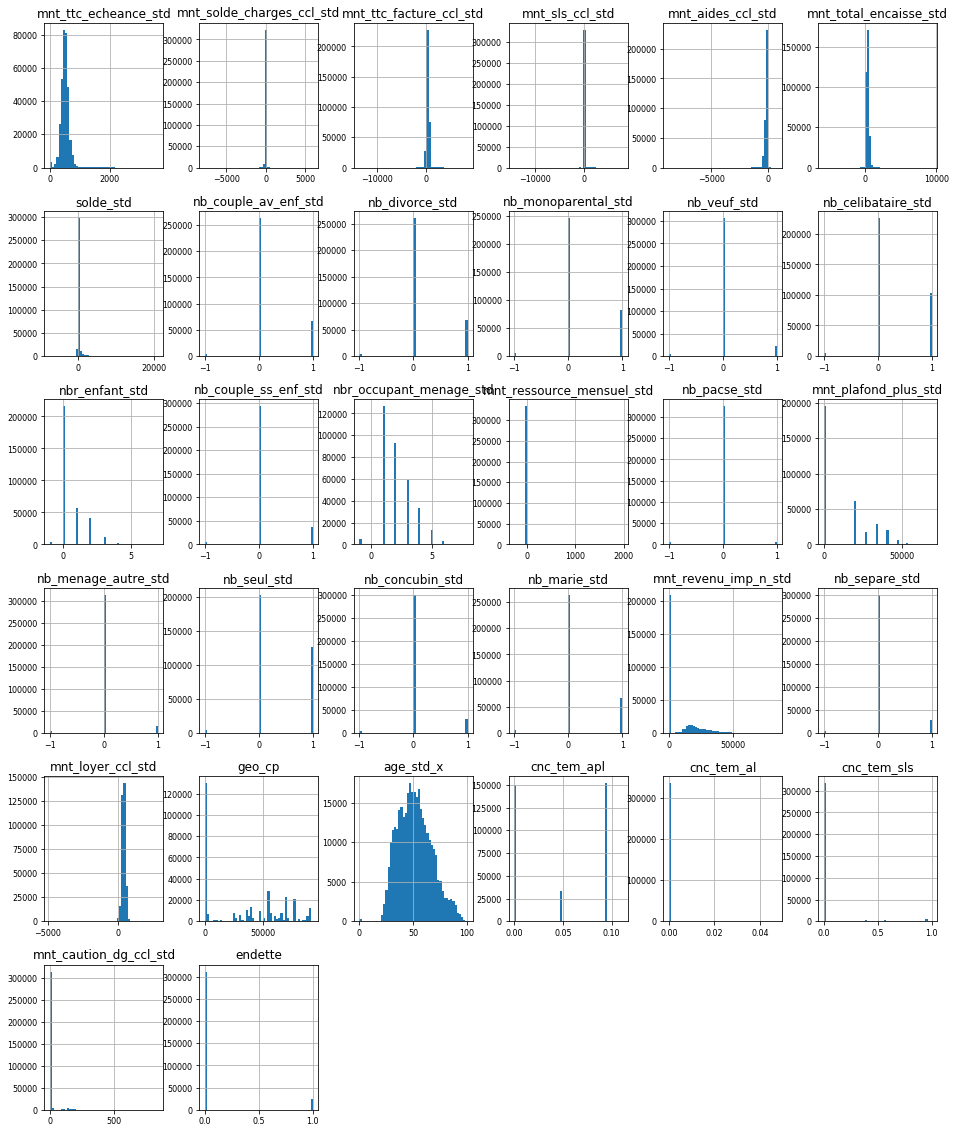

In [10]:
df_num.drop(["id_client", "date"], axis = 1).hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

2. **Correlation**

In [11]:
df_num_corr = df_num.drop(["id_client", "date"], axis = 1).corr()['endette'][:-1] # -1 because the latest row is endette
golden_features_list = df_num_corr[abs(df_num_corr) > 0.5].sort_values(ascending=False)
print("There is {} strongly correlated values with endette:\n{}".format(len(golden_features_list), golden_features_list))

There is 1 strongly correlated values with endette:
solde_std    0.596583
Name: endette, dtype: float64


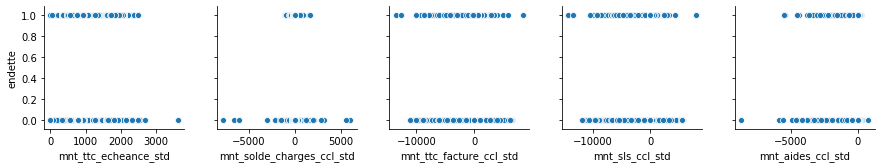

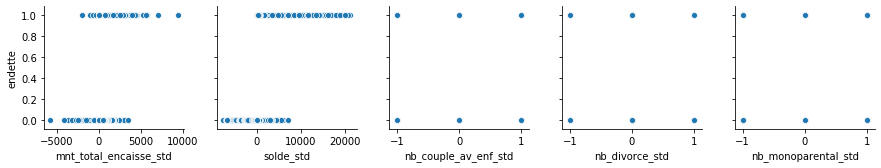

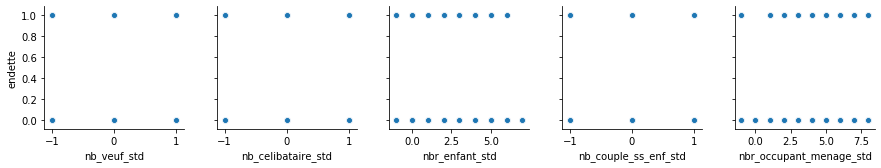

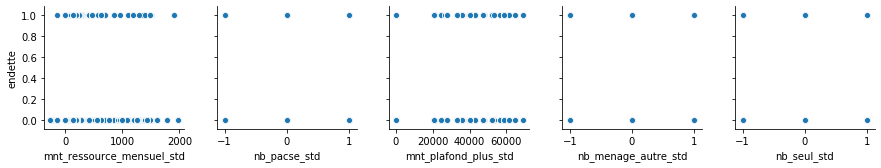

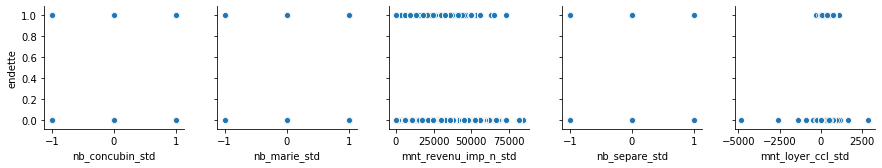

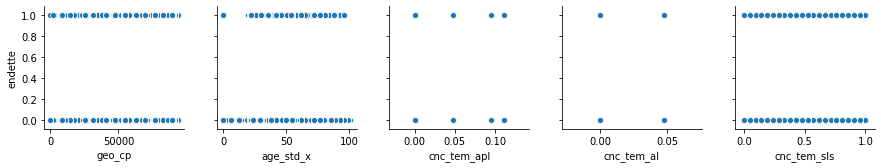

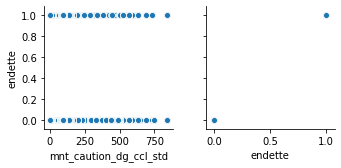

In [12]:
for i in range(0, len(df_num.drop(["id_client", "date"], axis = 1).columns), 5):
    sns.pairplot(data=df_num.drop(["id_client", "date"], axis = 1),
                 x_vars=df_num.drop(["id_client", "date"], axis = 1).columns[i:i+5],
                 y_vars=['endette'])
    plt.show()

In [13]:
import operator

individual_features_df = []
for i in range(0, len(df_num.drop(["id_client", "date"], axis = 1).columns) - 1): # -1 because the last column is endette
    tmpDf = df_num[[df_num.drop(["id_client", "date"], axis = 1).columns[i], 'endette']]
    tmpDf = tmpDf[tmpDf[df_num.drop(["id_client", "date"], axis = 1).columns[i]] != 0]
    individual_features_df.append(tmpDf)

all_correlations = {feature.columns[0]: feature.corr()['endette'][0] for feature in individual_features_df}
all_correlations = sorted(all_correlations.items(), key=operator.itemgetter(1))
for (key, value) in all_correlations:
    print("{:>15}: {:>15}".format(key, value))

    nb_veuf_std: -0.2441966038399639
   nb_pacse_std: -0.22511230225585752
nb_couple_ss_enf_std: -0.17392676795389808
nb_menage_autre_std: -0.1638961227043843
 nb_divorce_std: -0.15757256916786244
    cnc_tem_apl: -0.13721405162769998
   nb_marie_std: -0.12050449172080188
    nb_seul_std: -0.1163688110609144
  nb_separe_std: -0.11179917627181364
nb_concubin_std: -0.10806930040422774
nb_celibataire_std: -0.09320460954038162
nb_couple_av_enf_std: -0.09197590272069342
nb_monoparental_std: -0.0901536363901659
      age_std_x: -0.08960810162532014
mnt_revenu_imp_n_std: -0.08937354540048194
mnt_aides_ccl_std: -0.050421422131880556
    cnc_tem_sls: -0.04863381071086801
mnt_ressource_mensuel_std: -0.04796833800606619
         geo_cp: -0.028512136381590752
 nbr_enfant_std: -0.0165727093589105
mnt_sls_ccl_std: -0.0012703007265724212
     cnc_tem_al: -9.401150911208528e-17
mnt_ttc_facture_ccl_std: 0.013644991750000562
mnt_loyer_ccl_std: 0.013987474206887356
mnt_plafond_plus_std: 0.014453235659035

In [14]:
golden_features_list = [key for key, value in all_correlations if abs(value) >= 0.5]
print("There is {} strongly correlated values with endette:\n{}".format(len(golden_features_list), golden_features_list))

There is 1 strongly correlated values with endette:
['solde_std']


In [15]:
date = pd.unique(data.date).tolist()
mean_endette = np.mean(pourcentage) * 100
pourcentage_df = pd.DataFrame({"date": date, "pourcentage": [x * 100 for x in pourcentage]}).set_index("date")
pourcentage_df

,pourcentage
date,
20180131,8.949416
20180228,7.003891
20180331,6.947408
20180430,7.644032
20180531,7.041546
20180630,6.664993
20180731,6.326095
20180831,6.370026
20180930,6.401406


In [16]:
def visualisation(data, titre) :
    fig, ax = plt.subplots()
    sns.boxplot(data=data)
    plt.title(titre)
    plt.savefig("boxplot_dette_du_mois.png")
    plt.show()

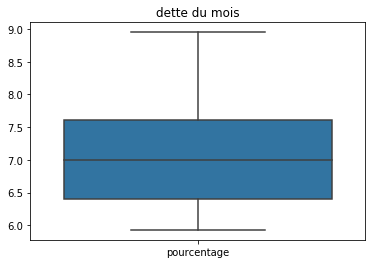

In [17]:
visualisation(pourcentage_df, 'dette du mois')

In [18]:
def surendetteplot(data, typeplot, title) :
    if (typeplot == "line") :
        index = data.index.values.tolist()
        cols = [str(x) for x in index]
        fig, ax = plt.subplots()
        sns.lineplot(x=cols, y = data['pourcentage'])
        sns.lineplot(x=cols, y = [mean_endette] * len(data.index.values), color='red')
        ax.set_xticks(range(len(cols)))
        ax.set_xticklabels(cols)
        plt.xticks(rotation = 90)
        plt.title("lineplot " + title)
        plt.ylabel("pourcentage des personnes en dette")
        plt.xlabel("date")
        plt.savefig('lineplot_pourcentage_des_personnes_en_dette.png')
        plt.show()
    if (typeplot == "bar") :
        index = data.index.values.tolist()
        cols = [str(x) for x in index]
        fig, ax = plt.subplots()
        sns.barplot(x=cols, y = data['pourcentage'])
        sns.lineplot(x=cols, y = [mean_endette] * len(data.index.values), color='red')
        ax.set_xticks(range(len(cols)))
        ax.set_xticklabels(cols)
        plt.xticks(rotation = 90)
        plt.title("barplot " + title)
        plt.ylabel("pourcentage des personnes en dette")
        plt.xlabel("date")
        plt.savefig('barplot_pourcentage_des_personnes_en_dette.png')
        plt.show()

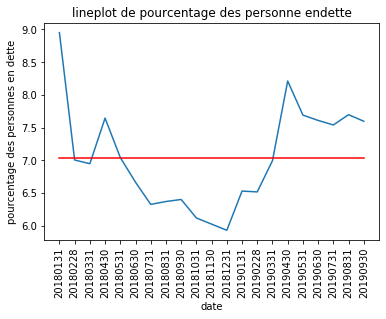

In [19]:
surendetteplot(pourcentage_df, "line", "de pourcentage des personne endette")

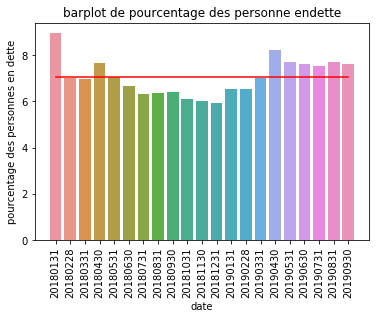

In [20]:
surendetteplot(pourcentage_df, "bar", "de pourcentage des personne endette")

In [21]:
data_analyse = data.drop(["mnt_ttc_echeance_std", "mnt_solde_charges_ccl_std", "mnt_ttc_facture_ccl_std",
                          "mnt_sls_ccl_std", "mnt_total_encaisse_std", "mnt_ressource_mensuel_std",
                          "mnt_plafond_plus_std", "mnt_caution_dg_ccl_std"], axis = 1)
data_analyse

,id_client,date,mnt_aides_ccl_std,solde_std,nb_couple_av_enf_std,nb_divorce_std,nb_monoparental_std,nb_veuf_std,nb_celibataire_std,nbr_enfant_std,...,geo_localite,terme_lib,age_std_x,type_trf_lib,elo_categ_financement_inii,cnc_tem_apl,cnc_tem_al,cnc_tem_sls,cnc_dtdval,endette
0,0,20180131,0.0,-81.18,1.0,0.0,0.0,0.0,0.0,0.0,...,-1,TERME ECHU,50.0,Relocation,PLC,0.0,0.0,0.0,2018-01-31,0
1,0,20180228,0.0,-82.33,1.0,0.0,0.0,0.0,0.0,0.0,...,-1,TERME ECHU,50.0,Relocation,PLC,0.0,0.0,0.0,2018-01-31,0
2,0,20180331,0.0,-83.48,1.0,0.0,0.0,0.0,0.0,0.0,...,-1,TERME ECHU,50.0,Relocation,PLC,0.0,0.0,0.0,2018-01-31,0
3,0,20180430,0.0,-84.63,1.0,0.0,0.0,0.0,0.0,0.0,...,-1,TERME ECHU,50.0,Relocation,PLC,0.0,0.0,0.0,2018-01-31,0
4,0,20180531,0.0,-85.78,1.0,0.0,0.0,0.0,0.0,0.0,...,-1,TERME ECHU,50.0,Relocation,PLC,0.0,0.0,0.0,2018-01-31,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334690,19749,20190531,0.0,0.00,0.0,1.0,1.0,0.0,0.0,2.0,...,ROYON,TERME ECHU,50.0,Relocation,PL2,0.0,0.0,0.0,2018-01-31,0
334691,19749,20190630,0.0,0.00,0.0,1.0,1.0,0.0,0.0,2.0,...,ROYON,TERME ECHU,50.0,Relocation,PL2,0.0,0.0,0.0,2018-01-31,0
334692,19749,20190731,0.0,0.00,0.0,1.0,1.0,0.0,0.0,2.0,...,ROYON,TERME ECHU,50.0,Relocation,PL2,0.0,0.0,0.0,2018-01-31,0
334693,19749,20190831,0.0,0.00,0.0,1.0,1.0,0.0,0.0,2.0,...,ROYON,TERME ECHU,50.0,Relocation,PL2,0.0,0.0,0.0,2018-01-31,0


In [22]:
for i in pd.unique(data_analyse.date) :
    data_test = data_analyse[data_analyse.date == i]
    if len(pd.unique(data_analyse.id_client)) == len(pd.unique(data_test.id_client)) :
        print(i)

20190131
20190228
20190331
20190430
20190531
20190630
20190731
20190831
20190930


In [23]:
# jan_2018 = data_analyse[data_analyse.date == 20180131]
# print(len(pd.unique(jan_2018.id_client)))

In [24]:
# jan_2019 = data_analyse[data_analyse.date == 20190131]
# print(len(pd.unique(jan_2019.id_client)))
# print(len(pd.unique(data.id_client)))

In [25]:
jan_2019_df = data_analyse[data_analyse.date == 20190131].reset_index(drop=True)
jan_2019_df.head()

,id_client,date,mnt_aides_ccl_std,solde_std,nb_couple_av_enf_std,nb_divorce_std,nb_monoparental_std,nb_veuf_std,nb_celibataire_std,nbr_enfant_std,...,geo_localite,terme_lib,age_std_x,type_trf_lib,elo_categ_financement_inii,cnc_tem_apl,cnc_tem_al,cnc_tem_sls,cnc_dtdval,endette
0,0,20190131,0.00,-3.93,0.0,0.0,0.0,0.0,0.0,0.0,...,-1,TERME ECHU,50.0,Relocation,PLC,0.000000,0.0,0.0,2018-01-31,0
1,1,20190131,-101.54,-264.96,1.0,0.0,0.0,0.0,0.0,0.0,...,-1,TERME ECHU,35.0,Relocation,PLC,0.095238,0.0,0.0,2018-01-31,0
2,2,20190131,0.00,709.41,1.0,0.0,0.0,0.0,0.0,0.0,...,-1,TERME ECHU,31.0,Relocation,PLC,0.000000,0.0,0.0,2018-01-31,0
3,3,20190131,0.00,0.00,0.0,0.0,1.0,0.0,1.0,0.0,...,-1,TERME ECHU,48.0,Relocation,-1,0.000000,0.0,0.0,2018-01-31,0
4,6,20190131,0.00,50.00,0.0,1.0,0.0,0.0,0.0,0.0,...,ROYON,TERME ECHU,75.0,Relocation,PLA,0.000000,0.0,0.0,2018-01-31,0


In [26]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder, StandardScaler
test_df = jan_2019_df.drop(["id_client", "date"], axis = 1)
test_df = test_df.drop(["cnc_dtdval", "endette"], axis = 1)
object_cols = [x for x in test_df.columns if test_df[x].dtype != np.int and test_df[x].dtype != np.float]
object_cols

object_cols = [x for x in object_cols if len(test_df[x].unique()) > 1]
object_cols

['type_revenu_lib',
 'cnc_dteff',
 'geo_cp',
 'geo_region_lib',
 'elo_etage',
 'type_cnc_lib',
 'type_elo_lib',
 'elo_dtf_construction',
 'elo_mode_chauffage',
 'geo_localite',
 'terme_lib',
 'type_trf_lib',
 'elo_categ_financement_inii']

In [27]:
pd.get_dummies(test_df[object_cols])

,geo_cp,type_revenu_lib_-1,type_revenu_lib_All. Adulte Handicapés,type_revenu_lib_All. Chomage_Indemnités,type_revenu_lib_Allo. Minimum Vieillesse,type_revenu_lib_Allocation Jeune Enfant,type_revenu_lib_Allocation familiales,type_revenu_lib_Autre (hors APL ou AL),type_revenu_lib_Pens. alimentaire reçue,type_revenu_lib_Pension d'invalidité,...,elo_categ_financement_inii_PL2,elo_categ_financement_inii_PLA,elo_categ_financement_inii_PLB,elo_categ_financement_inii_PLC,elo_categ_financement_inii_PLI,elo_categ_financement_inii_PLM,elo_categ_financement_inii_PLQ,elo_categ_financement_inii_PLU,elo_categ_financement_inii_PSR,elo_categ_financement_inii_PTS
0,-1,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,-1,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,-1,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,-1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,62990,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15938,2140,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15939,-1,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
15940,-1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15941,69360,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
scaler = StandardScaler()
scaler.fit(test_df.drop(object_cols, axis = 1))
scaler.transform(test_df.drop(object_cols, axis = 1))

scale_data = pd.DataFrame(scaler.transform(test_df.drop(object_cols, axis = 1)), columns = test_df.drop(object_cols, axis = 1).columns)
scale_data

,mnt_aides_ccl_std,solde_std,nb_couple_av_enf_std,nb_divorce_std,nb_monoparental_std,nb_veuf_std,nb_celibataire_std,nbr_enfant_std,nb_couple_ss_enf_std,nbr_occupant_menage_std,...,nb_seul_std,nb_concubin_std,nb_marie_std,mnt_revenu_imp_n_std,nb_separe_std,mnt_loyer_ccl_std,age_std_x,cnc_tem_apl,cnc_tem_al,cnc_tem_sls
0,0.694258,-0.163498,-0.391085,-0.405073,-0.466596,-0.147103,-0.562486,-0.572706,2.559902,-0.069224,...,-0.669596,-0.194466,1.900154,1.714679,-0.187062,0.881253,-0.118343,-1.058135,-0.011201,-0.218008
1,-0.026014,-0.618818,1.897012,-0.405073,-0.466596,-0.147103,-0.562486,-0.572706,-0.239694,0.687731,...,-0.669596,-0.194466,1.900154,-0.679067,-0.187062,2.262439,-1.089818,1.047831,-0.011201,-0.218008
2,0.694258,1.080798,1.897012,-0.405073,-0.466596,-0.147103,-0.562486,-0.572706,-0.239694,1.444686,...,-0.669596,2.827338,-0.390173,-0.679067,-0.187062,2.436366,-1.348879,-1.058135,-0.011201,-0.218008
3,0.694258,-0.156642,-0.391085,-0.405073,1.663685,-0.147103,1.429897,-0.572706,-0.239694,-0.069224,...,-0.669596,-0.194466,-0.390173,0.168697,-0.187062,1.007762,-0.247873,-1.058135,-0.011201,-0.218008
4,0.694258,-0.069426,-0.391085,1.849845,-0.466596,-0.147103,-0.562486,-0.572706,-0.239694,-0.826179,...,1.228247,-0.194466,-0.390173,0.255055,-0.187062,-1.375345,1.500784,-1.058135,-0.011201,-0.218008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15938,0.694258,-0.156642,-0.391085,-0.405073,1.663685,-0.147103,-0.562486,-0.572706,-0.239694,0.687731,...,-0.669596,-0.194466,-0.390173,-0.679067,2.874882,-3.623544,-1.413644,1.398826,-0.011201,-0.218008
15939,0.694258,-0.156642,-0.391085,-0.405073,1.663685,-0.147103,1.429897,-0.572706,-0.239694,0.687731,...,-0.669596,-0.194466,-0.390173,0.695702,-0.187062,-3.623544,-1.478409,-1.058135,-0.011201,-0.218008
15940,0.694258,-0.156642,1.897012,-0.405073,-0.466596,-0.147103,-0.562486,1.557388,-0.239694,1.444686,...,-0.669596,-0.194466,1.900154,2.161178,-0.187062,-3.623544,-0.895523,-1.058135,-0.011201,-0.218008
15941,0.694258,-0.156642,-0.391085,-0.405073,1.663685,-0.147103,-0.562486,0.492341,-0.239694,-0.069224,...,-0.669596,-0.194466,-0.390173,-0.192552,2.874882,-3.623544,-0.312638,-1.058135,-0.011201,-0.218008


In [29]:
scale_data = pd.concat([scale_data, pd.get_dummies(test_df[object_cols]), jan_2019_df[["id_client"]]], axis = 1)
scale_data

,mnt_aides_ccl_std,solde_std,nb_couple_av_enf_std,nb_divorce_std,nb_monoparental_std,nb_veuf_std,nb_celibataire_std,nbr_enfant_std,nb_couple_ss_enf_std,nbr_occupant_menage_std,...,elo_categ_financement_inii_PLA,elo_categ_financement_inii_PLB,elo_categ_financement_inii_PLC,elo_categ_financement_inii_PLI,elo_categ_financement_inii_PLM,elo_categ_financement_inii_PLQ,elo_categ_financement_inii_PLU,elo_categ_financement_inii_PSR,elo_categ_financement_inii_PTS,id_client
0,0.694258,-0.163498,-0.391085,-0.405073,-0.466596,-0.147103,-0.562486,-0.572706,2.559902,-0.069224,...,0,0,1,0,0,0,0,0,0,0
1,-0.026014,-0.618818,1.897012,-0.405073,-0.466596,-0.147103,-0.562486,-0.572706,-0.239694,0.687731,...,0,0,1,0,0,0,0,0,0,1
2,0.694258,1.080798,1.897012,-0.405073,-0.466596,-0.147103,-0.562486,-0.572706,-0.239694,1.444686,...,0,0,1,0,0,0,0,0,0,2
3,0.694258,-0.156642,-0.391085,-0.405073,1.663685,-0.147103,1.429897,-0.572706,-0.239694,-0.069224,...,0,0,0,0,0,0,0,0,0,3
4,0.694258,-0.069426,-0.391085,1.849845,-0.466596,-0.147103,-0.562486,-0.572706,-0.239694,-0.826179,...,1,0,0,0,0,0,0,0,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15938,0.694258,-0.156642,-0.391085,-0.405073,1.663685,-0.147103,-0.562486,-0.572706,-0.239694,0.687731,...,0,0,0,0,0,0,0,0,0,19212
15939,0.694258,-0.156642,-0.391085,-0.405073,1.663685,-0.147103,1.429897,-0.572706,-0.239694,0.687731,...,1,0,0,0,0,0,0,0,0,19305
15940,0.694258,-0.156642,1.897012,-0.405073,-0.466596,-0.147103,-0.562486,1.557388,-0.239694,1.444686,...,0,0,0,0,0,0,0,0,0,19354
15941,0.694258,-0.156642,-0.391085,-0.405073,1.663685,-0.147103,-0.562486,0.492341,-0.239694,-0.069224,...,0,0,0,0,0,0,0,0,0,19735


In [30]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 3)
pca.fit(scale_data.drop('id_client', axis = 1))
scl_data = pca.transform(scale_data.drop('id_client', axis = 1))
scl_data = pd.DataFrame(scl_data, columns=["X1", "X2", "X3"])
pca.explained_variance_ratio_

array([9.99999972e-01, 3.98310331e-09, 2.88621900e-09])

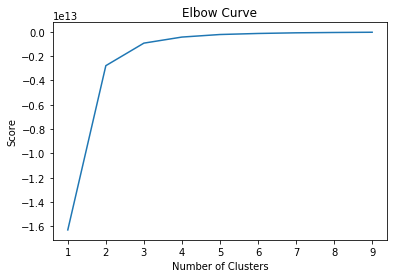

In [31]:
Nc = range(1, 10)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(scl_data).score(scl_data) for i in range(len(kmeans))]
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [32]:
model = KMeans(n_clusters = 3)
model.fit(scl_data)
model.labels_

array([1, 1, 1, ..., 1, 2, 2])

In [33]:
centers = np.array(model.cluster_centers_)

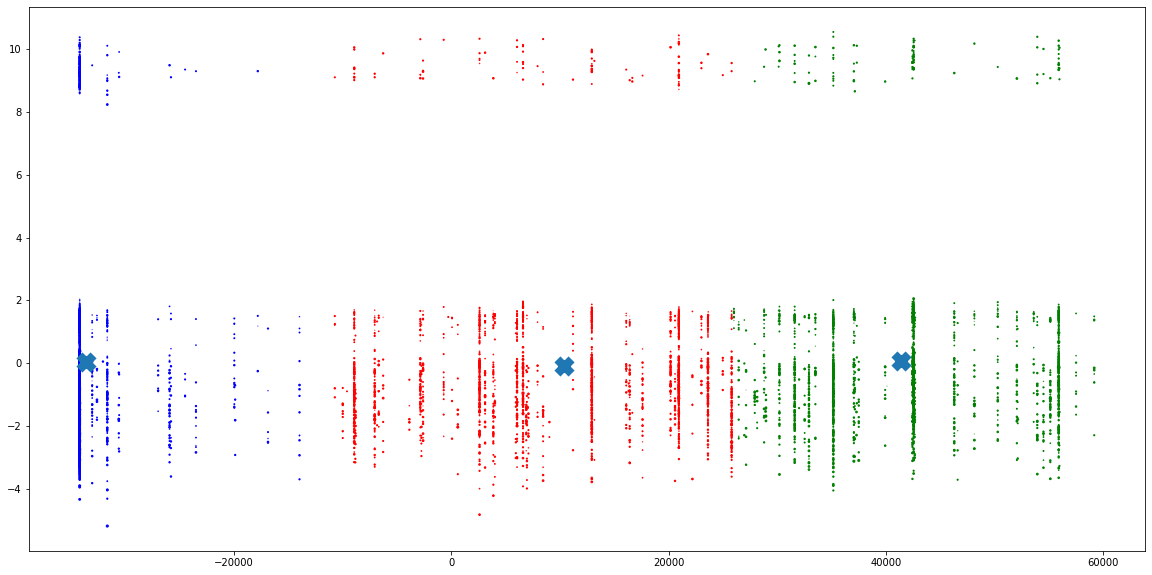

In [34]:
fig = plt.figure(figsize=(20, 10))
colormap = np.array(['Red', 'Blue', 'Green'])
plt.scatter(scl_data.X1, scl_data.X2, scl_data.X3, c = colormap[model.labels_])
plt.scatter(centers[:, 0], centers[:, 1], marker="x", linewidth = 20)
plt.show()

In [35]:
jan_2019_df["cluster"] = model.labels_

In [36]:
cluster = jan_2019_df[["id_client", "cluster"]]
jan_2018 = data_analyse[data_analyse.date == 20180131]
jan_2018 = pd.merge(jan_2018, cluster, how="left", on="id_client")

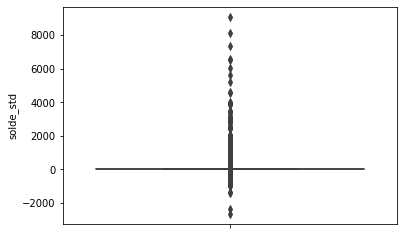

In [37]:
sns.boxplot(y = jan_2018[jan_2018.cluster == 0]["solde_std"])

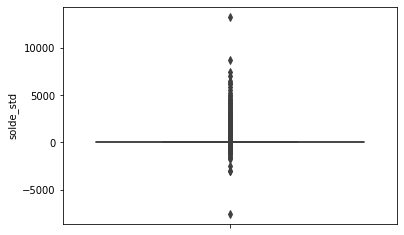

In [38]:
sns.boxplot(y = jan_2018[jan_2018.cluster == 1]["solde_std"])

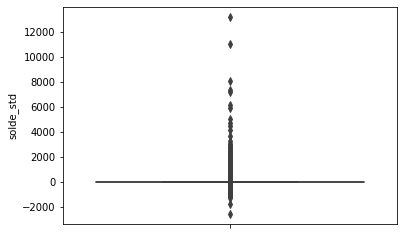

In [39]:
sns.boxplot(y = jan_2018[jan_2018.cluster == 2]["solde_std"])

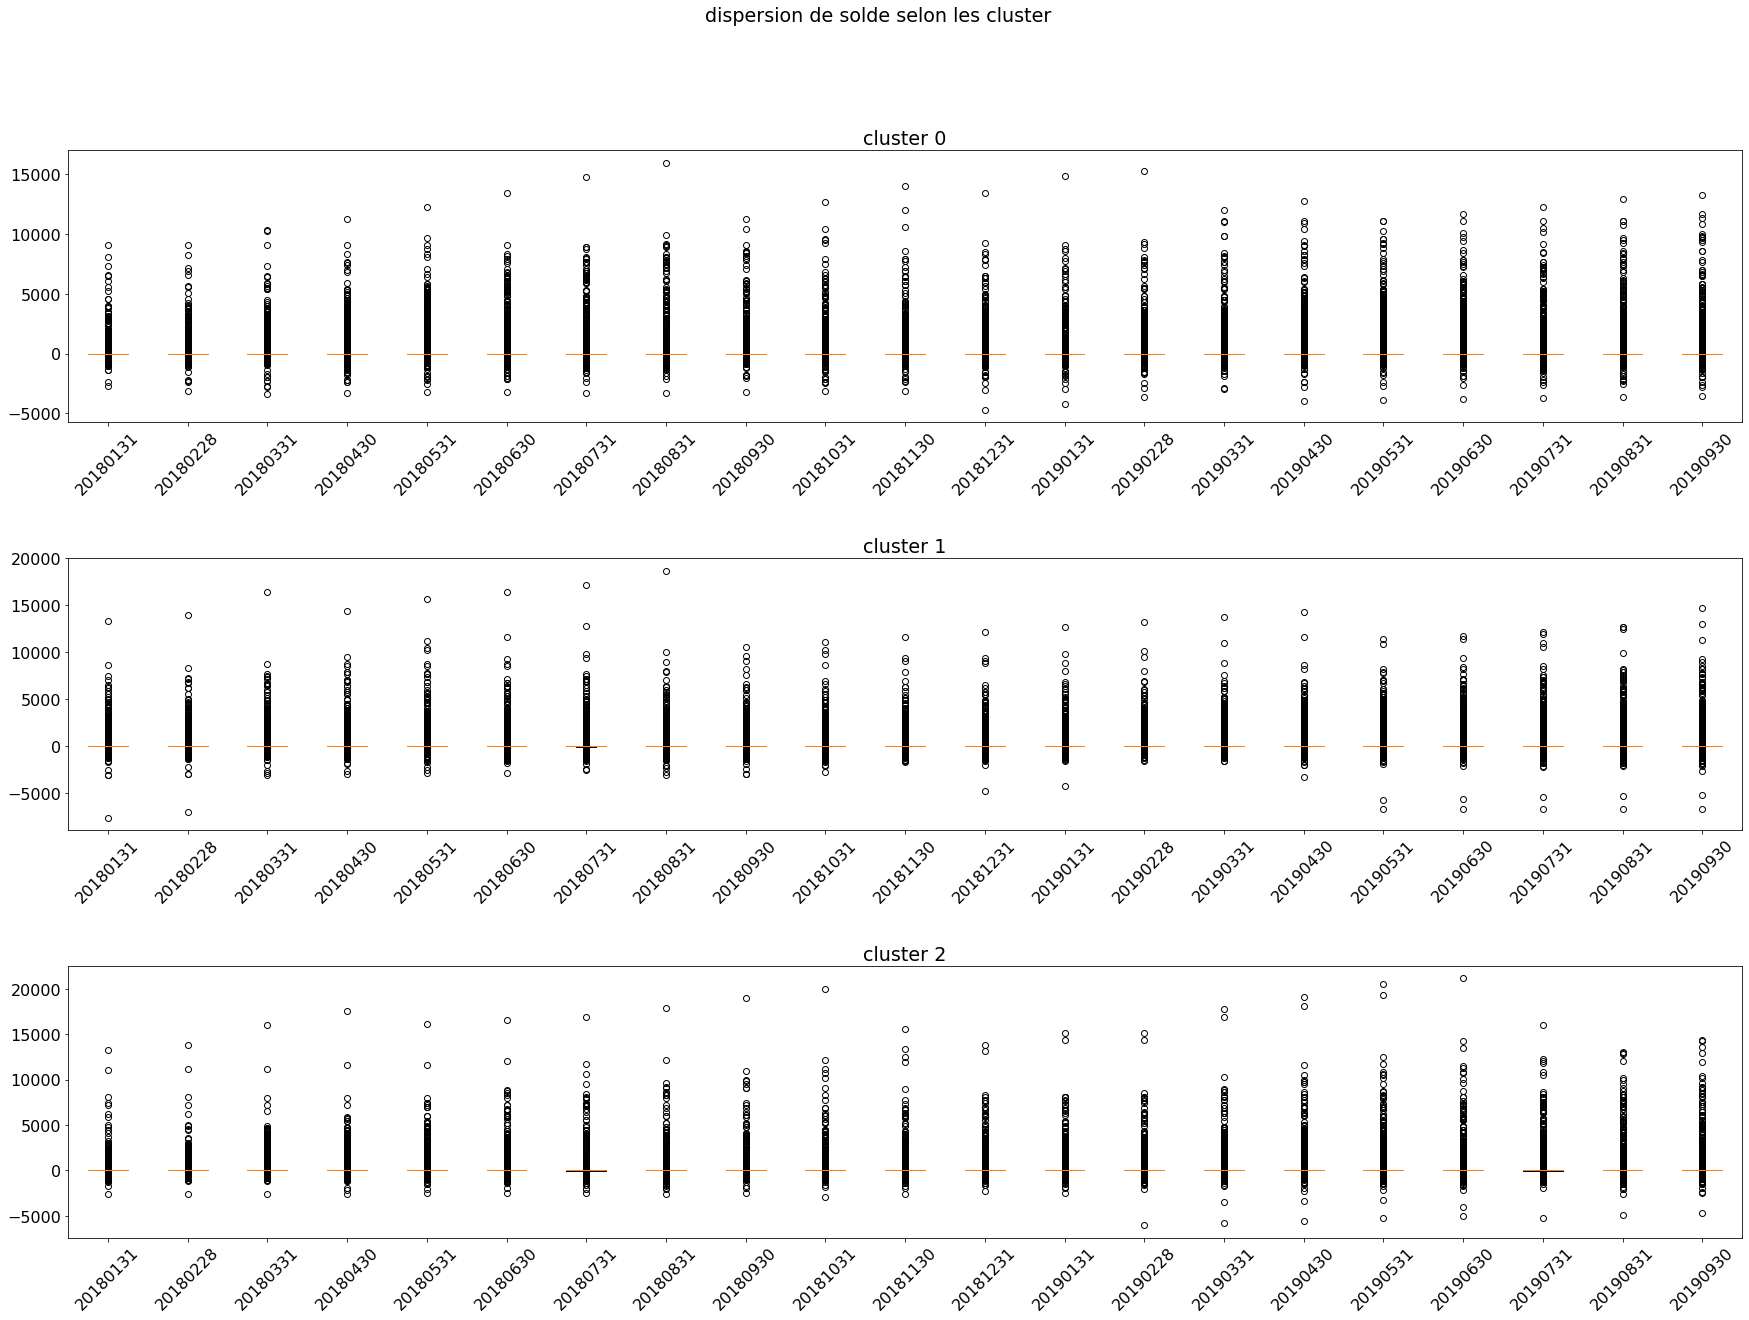

In [40]:
plt.rcParams.update({'font.size': 16})
fig = plt.figure(figsize=(30, 20))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
ax0 = plt.subplot(311)
ax1 = plt.subplot(312)
ax2 = plt.subplot(313)

cluster0 = []
cluster1 = []
cluster2 = []

for i in pd.unique(data_analyse.date) :
    date_df = data_analyse[data_analyse.date == i]
    date_df = pd.merge(date_df, cluster, how="left", on="id_client")
    cluster0.append(date_df[date_df.cluster == 0].solde_std.values)
    cluster1.append(date_df[date_df.cluster == 1].solde_std.values)
    cluster2.append(date_df[date_df.cluster == 2].solde_std.values)
    
ax0.boxplot(cluster0)
ax0.set_xticklabels(pd.unique(data_analyse.date).tolist(), rotation=45)
ax0.set_title("cluster 0")

ax1.boxplot(cluster1)
ax1.set_xticklabels(pd.unique(data_analyse.date).tolist(), rotation=45)
ax1.set_title("cluster 1")

ax2.boxplot(cluster2)
ax2.set_xticklabels(pd.unique(data_analyse.date).tolist(), rotation=45)
ax2.set_title("cluster 2")

fig.suptitle("dispersion de solde selon les cluster")
plt.savefig("cluster.png")
plt.show()

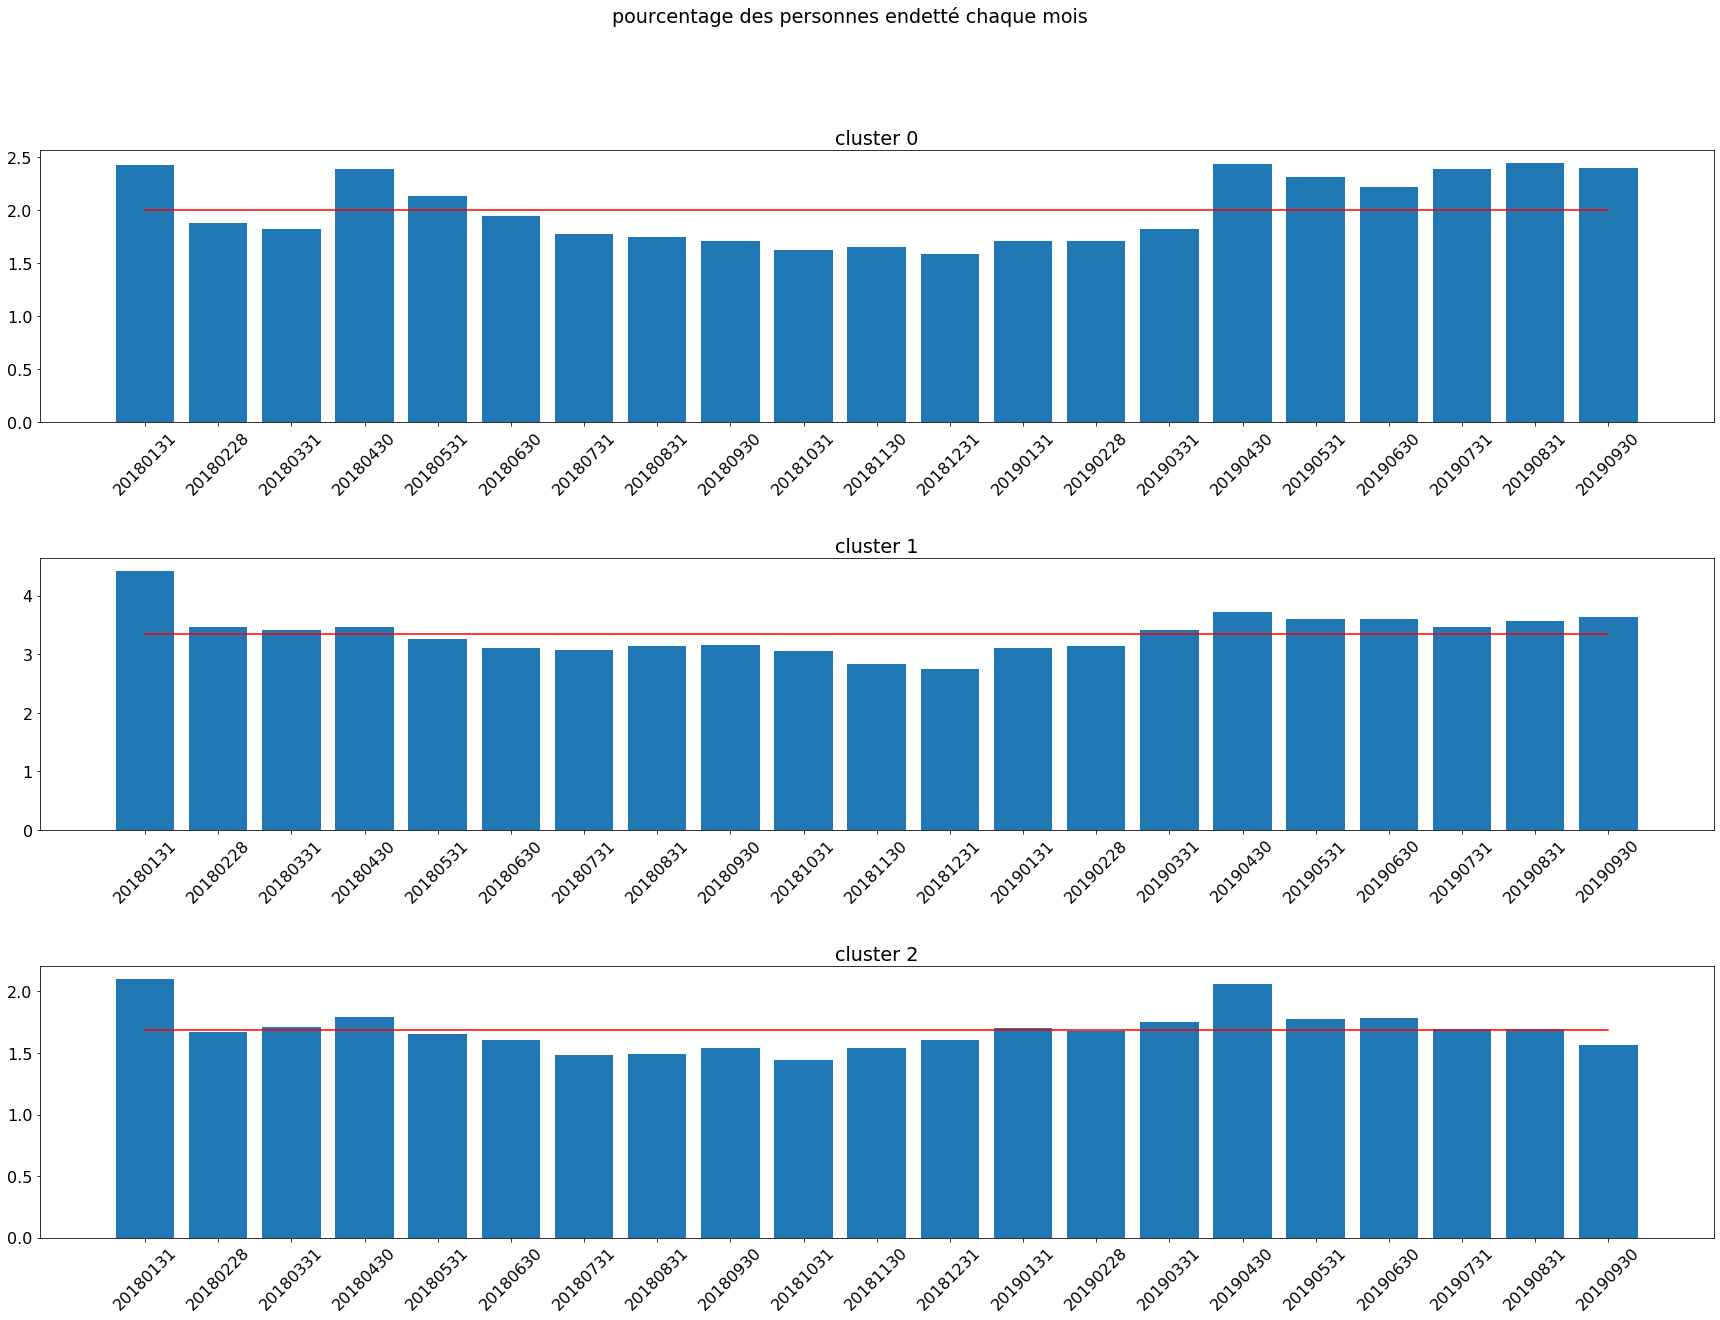

In [41]:
plt.rcParams.update({'font.size': 16})
fig = plt.figure(figsize=(30, 20))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
ax0 = plt.subplot(311)
ax1 = plt.subplot(312)
ax2 = plt.subplot(313)

cluster0 = []
cluster1 = []
cluster2 = []


for i in pd.unique(data_analyse.date) :
    date_df = data_analyse[data_analyse.date == i]
    date_df = pd.merge(date_df, cluster, how="left", on="id_client")
    cluster0.append(date_df[date_df.cluster == 0].endette.sum()/len(date_df)*100)
    cluster1.append(date_df[date_df.cluster == 1].endette.sum()/len(date_df)*100)
    cluster2.append(date_df[date_df.cluster == 2].endette.sum()/len(date_df)*100)

mean_cluster0 = np.mean(cluster0)    
mean_cluster1 = np.mean(cluster1)
mean_cluster2 = np.mean(cluster2)

    
ax0.bar(range(21), cluster0)
ax0.plot(range(21), [mean_cluster0] * 21, color="red")
ax0.set_xticks(range(21))
ax0.set_xticklabels(pd.unique(data_analyse.date).tolist(), rotation=45)
ax0.set_title("cluster 0")

ax1.bar(range(21), cluster1)
ax1.plot(range(21), [mean_cluster1] * 21, color="red")
ax1.set_xticks(range(21))
ax1.set_xticklabels(pd.unique(data_analyse.date).tolist(), rotation=45)
ax1.set_title("cluster 1")


ax2.bar(range(21), cluster2)
ax2.plot(range(21), [mean_cluster2] * 21, color="red")
ax2.set_xticklabels(pd.unique(data_analyse.date).tolist(), rotation=45)
ax2.set_xticks(range(21))
ax2.set_title("cluster 2")


fig.suptitle("pourcentage des personnes endetté chaque mois")
plt.savefig("pourcentage.png")

plt.show()

### SELECTION FEATURE 

In [42]:
cols_drop = [x for x in data.columns if data[x].dtype != np.int and data[x].dtype != np.float]
cols_drop

['id_client',
 'date',
 'type_revenu_lib',
 'cnc_dteff',
 'geo_cp',
 'geo_region_lib',
 'elo_etage',
 'type_cnc_lib',
 'type_elo_lib',
 'elo_dtf_construction',
 'elo_mode_chauffage',
 'geo_localite',
 'terme_lib',
 'type_trf_lib',
 'elo_categ_financement_inii',
 'cnc_dtdval',
 'endette']

In [43]:
data_dette = data[data.columns.drop(cols_drop + ["solde_std"]).tolist() + ["endette"]]
data_dette

,mnt_ttc_echeance_std,mnt_solde_charges_ccl_std,mnt_ttc_facture_ccl_std,mnt_sls_ccl_std,mnt_aides_ccl_std,mnt_total_encaisse_std,nb_couple_av_enf_std,nb_divorce_std,nb_monoparental_std,nb_veuf_std,...,nb_marie_std,mnt_revenu_imp_n_std,nb_separe_std,mnt_loyer_ccl_std,age_std_x,cnc_tem_apl,cnc_tem_al,cnc_tem_sls,mnt_caution_dg_ccl_std,endette
0,528.85,0.0,528.85,0.0,0.0,530.00,1.0,0.0,0.0,0.0,...,1.0,30269.0,0.0,508.85,50.0,0.0,0.0,0.0,0.00,0
1,528.85,0.0,528.85,0.0,0.0,530.00,1.0,0.0,0.0,0.0,...,1.0,30269.0,0.0,508.85,50.0,0.0,0.0,0.0,0.00,0
2,528.85,0.0,528.85,0.0,0.0,530.00,1.0,0.0,0.0,0.0,...,1.0,30269.0,0.0,508.85,50.0,0.0,0.0,0.0,0.00,0
3,528.85,0.0,528.85,0.0,0.0,530.00,1.0,0.0,0.0,0.0,...,1.0,30269.0,0.0,508.85,50.0,0.0,0.0,0.0,0.00,0
4,528.85,0.0,528.85,0.0,0.0,530.00,1.0,0.0,0.0,0.0,...,1.0,30269.0,0.0,508.85,50.0,0.0,0.0,0.0,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334690,0.00,0.0,0.00,0.0,0.0,0.00,0.0,1.0,1.0,0.0,...,0.0,24697.0,0.0,0.00,50.0,0.0,0.0,0.0,485.53,0
334691,0.00,0.0,0.00,0.0,0.0,0.00,0.0,1.0,1.0,0.0,...,0.0,24697.0,0.0,0.00,50.0,0.0,0.0,0.0,485.53,0
334692,0.00,0.0,0.00,0.0,0.0,0.00,0.0,1.0,1.0,0.0,...,0.0,24697.0,0.0,0.00,50.0,0.0,0.0,0.0,485.53,0
334693,0.00,0.0,0.00,0.0,0.0,485.53,0.0,1.0,1.0,0.0,...,0.0,24697.0,0.0,0.00,50.0,0.0,0.0,0.0,485.53,0


### Lasso 

In [44]:
X_train, X_test, y_train, y_test = train_test_split(data_dette.drop(['endette'], axis=1),
                                                    data_dette['endette'],
                                                    test_size=0.3,
                                                    random_state=0)

In [45]:
scaler = StandardScaler()
scaler.fit(X_train.fillna(0))
model_lasso = LogisticRegression(C=1, penalty='l1', solver='liblinear')
sel_ = SelectFromModel(model_lasso)

In [46]:
sel_.fit(scaler.transform(X_train.fillna(0)), y_train)

SelectFromModel(estimator=LogisticRegression(C=1, penalty='l1',
                                             solver='liblinear'))

In [47]:
X_train_norm = scaler.transform(X_train.fillna(0))
X_test_norm = scaler.transform(X_test.fillna(0))

In [48]:
unique, counts = np.unique(sel_.get_support(), return_counts=True)
d = data_dette.drop("endette", axis=1).columns[sel_.get_support()].tolist()
d

['mnt_ttc_echeance_std',
 'mnt_solde_charges_ccl_std',
 'mnt_ttc_facture_ccl_std',
 'mnt_sls_ccl_std',
 'mnt_aides_ccl_std',
 'mnt_total_encaisse_std',
 'nb_couple_av_enf_std',
 'nb_divorce_std',
 'nb_monoparental_std',
 'nb_veuf_std',
 'nb_celibataire_std',
 'nbr_enfant_std',
 'nb_couple_ss_enf_std',
 'nbr_occupant_menage_std',
 'mnt_ressource_mensuel_std',
 'nb_pacse_std',
 'mnt_plafond_plus_std',
 'nb_menage_autre_std',
 'nb_seul_std',
 'nb_concubin_std',
 'nb_marie_std',
 'mnt_revenu_imp_n_std',
 'nb_separe_std',
 'mnt_loyer_ccl_std',
 'age_std_x',
 'cnc_tem_apl',
 'cnc_tem_al',
 'cnc_tem_sls',
 'mnt_caution_dg_ccl_std']

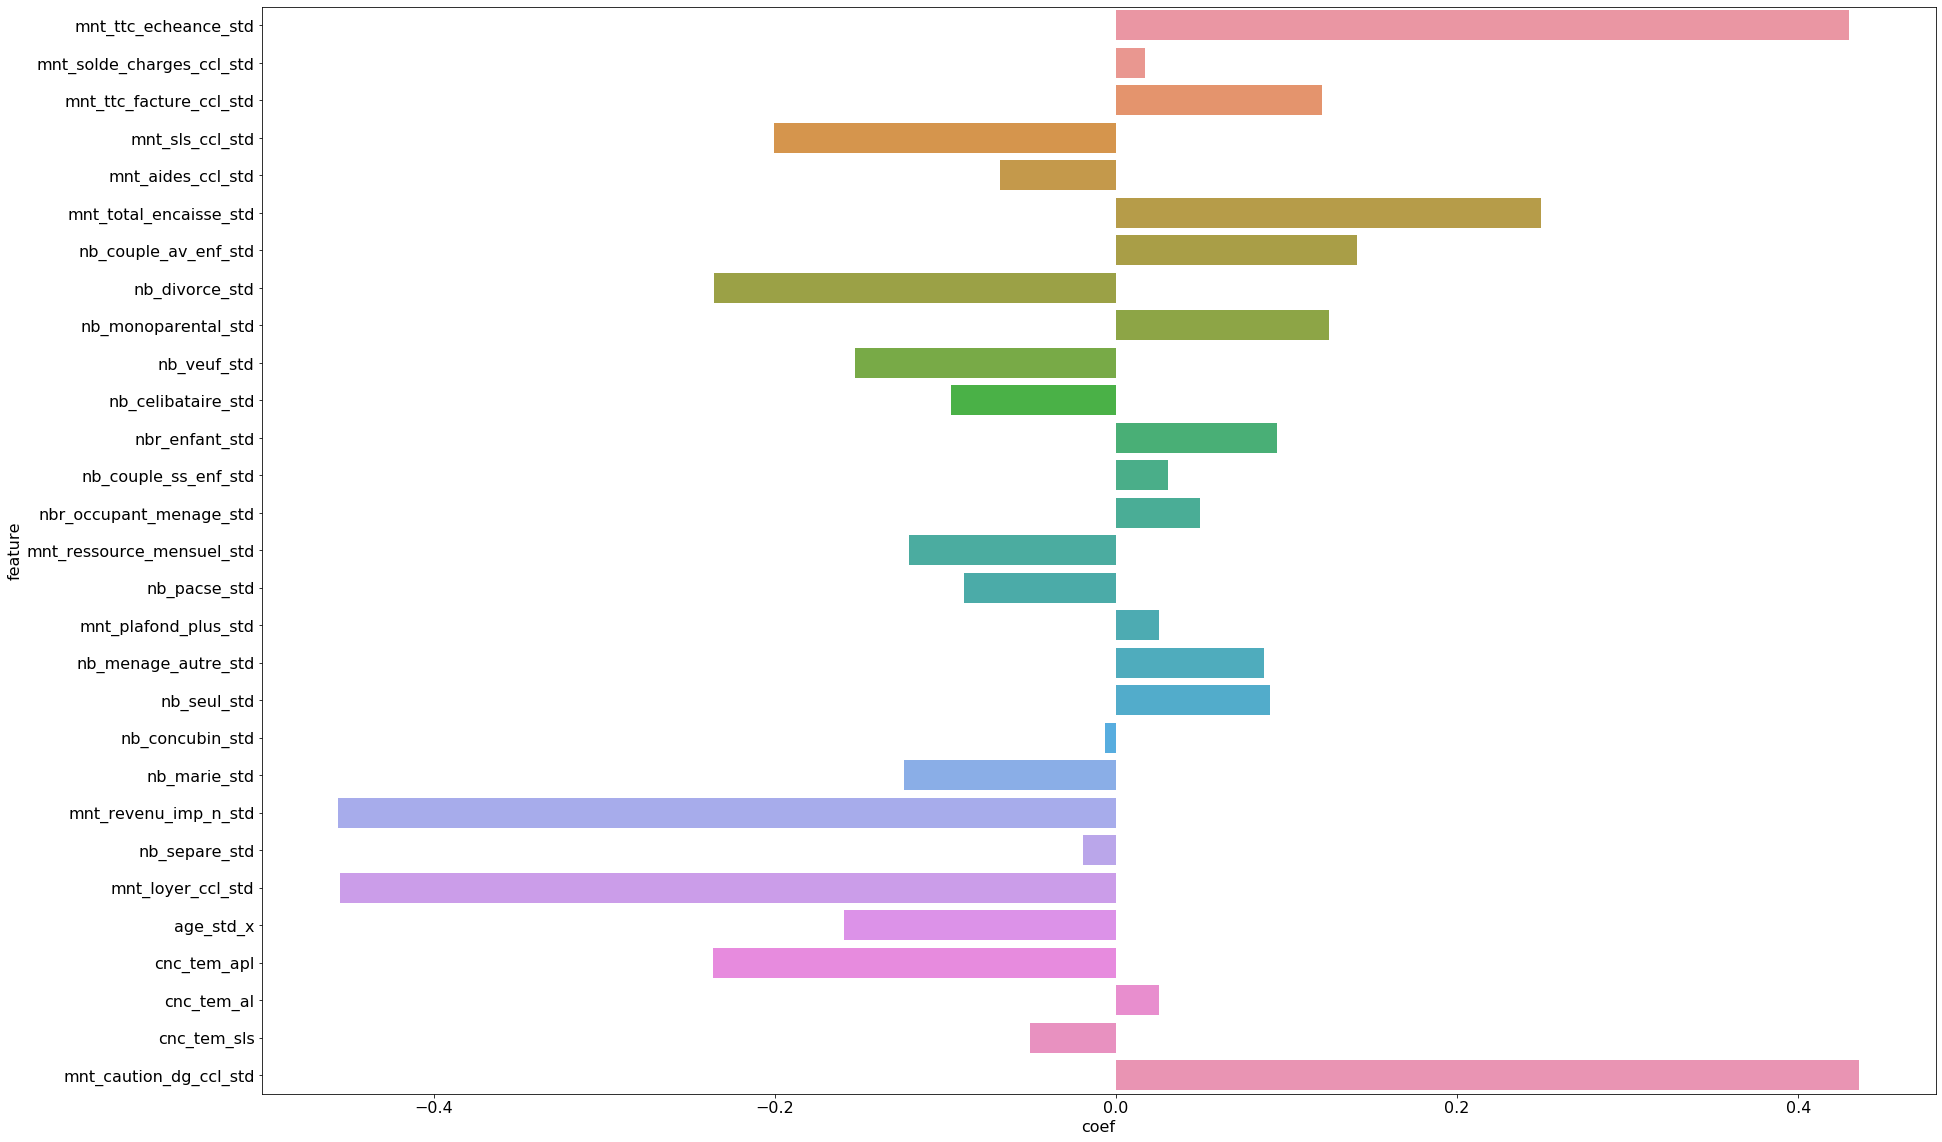

In [125]:
figure = plt.figure(figsize = (30, 20))
sns.barplot(x = "coef", y = "feature", data=pd.DataFrame({"feature" : d, "coef" : sel_.estimator_.coef_.ravel()}));

In [49]:
X_test_lasso = sel_.transform(scaler.transform(X_test.fillna(0)))
X_train_lasso = sel_.transform(scaler.transform(X_train.fillna(0)))

In [50]:
model_lasso = LogisticRegression(C=1, penalty='l1', solver='liblinear')

In [51]:
kfold = KFold(n_splits=10, random_state=42, shuffle=True)
scores_1 = cross_val_score(model_lasso, X_train_norm, y_train, cv = kfold)

In [52]:
np.mean(scores_1)

0.9259793592216935

In [53]:
kfold = KFold(n_splits=10, random_state=42, shuffle=True)
scores = cross_val_score(model_lasso, scaler.transform(data_dette.drop(['endette'], axis=1)), data_dette['endette'], cv = kfold)

In [54]:
scores

array([0.92829399, 0.92650134, 0.92488796, 0.92730804, 0.92647147,
       0.92401924, 0.92978577, 0.92730587, 0.92563268, 0.92566255])

In [55]:
np.mean(scores)

0.9265868909653635

In [56]:
scores_lasso = scores

In [57]:
model_lasso.fit(scaler.transform(X_train.fillna(0)), y_train)
y_hat = model_lasso.predict(scaler.transform(X_test.fillna(0)))
acc_lasso = accuracy_score(y_hat, y_test)

In [107]:
model_lasso.fit(scaler.transform(X_train.fillna(0)), y_train)
y_hat = model_lasso.predict(scaler.transform(X_test.fillna(0)))

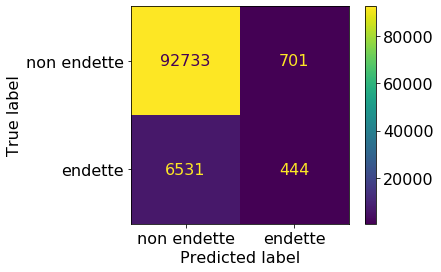

In [116]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model_lasso, scaler.transform(X_test.fillna(0)), y_test, display_labels = ["non endette", "endette"]) 
plt.show()

In [58]:
acc_lasso

0.9279745839516378

### Ridge 

In [59]:
scr = []

for alpha in np.arange(0.01, 1, 0.01) :
    ridge_model = RidgeClassifier(alpha = alpha)
    kfold = KFold(n_splits=10, random_state=42, shuffle=True)
    score = cross_val_score(ridge_model, X_train, y_train, cv = kfold)
    scr.append(np.mean(score))

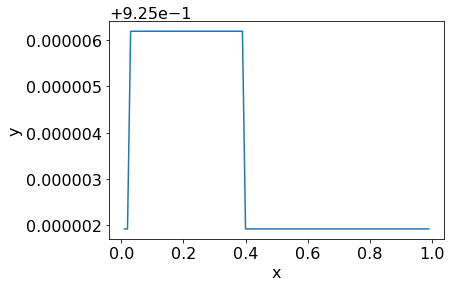

In [60]:
sns.lineplot(x = "x", y = "y", data=pd.DataFrame({"x" : np.arange(0.01, 1, 0.01), "y" : scr}));

In [61]:
opt_alpha = pd.DataFrame({"x" : np.arange(0.01, 1, 0.01), "y" : scr})
opt = opt_alpha[opt_alpha.y == np.max(opt_alpha.y)].x.values
opt = opt[0]

In [62]:
model_ridge = RidgeClassifier(alpha = opt)
kfold = KFold(n_splits=10, random_state=42, shuffle=True)
scores_1 = cross_val_score(model_ridge, X_train_norm, y_train, cv = kfold)

In [63]:
np.mean(scores_1)

0.9250019224091055

In [64]:
kfold = KFold(n_splits=10, random_state=42, shuffle=True)
scores = cross_val_score(model_ridge, scaler.transform(data_dette.drop(['endette'], axis=1)), data_dette['endette'], cv = kfold)

In [65]:
scores_ridge = scores

In [66]:
model_ridge.fit(scaler.transform(X_train.fillna(0)), y_train)
y_hat = model_ridge.predict(scaler.transform(X_test.fillna(0)))
acc_ridge = accuracy_score(y_hat, y_test)

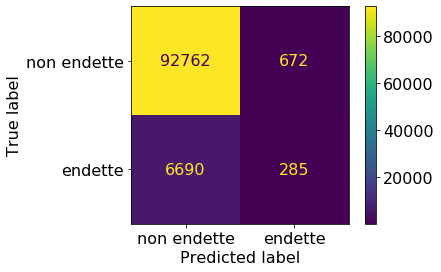

In [117]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model_ridge, scaler.transform(X_test.fillna(0)), y_test, display_labels = ["non endette", "endette"]) 
plt.show()

In [67]:
acc_ridge

0.9266798792936888

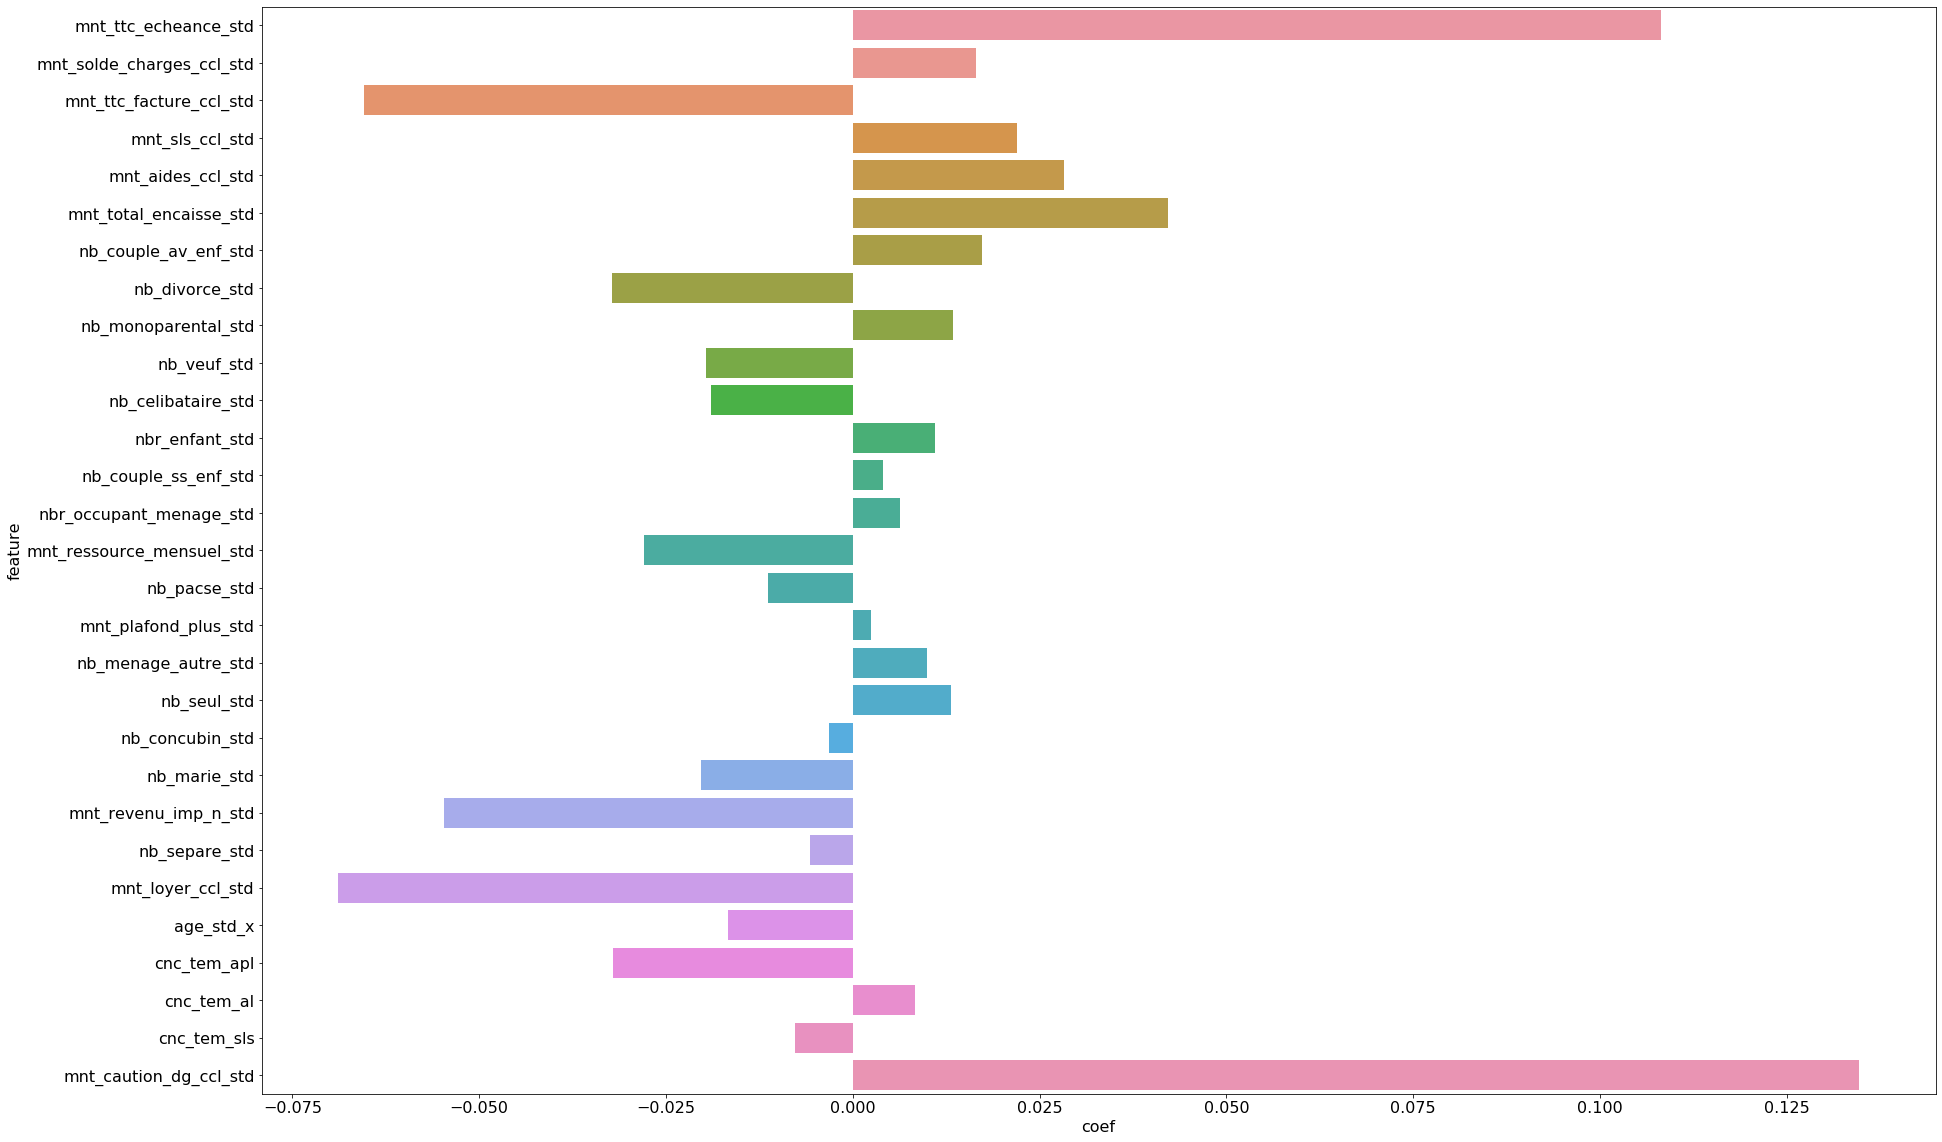

In [126]:
figure = plt.figure(figsize = (30, 20))
sns.barplot(x = "coef", y = "feature", data=pd.DataFrame({"feature" : X_test.columns.tolist(), "coef" : model_ridge.coef_.ravel()}));

### Random Forest

In [68]:
results = []
for max_features in np.arange(1, X_train.shape[1]):
    print(max_features)
    regr   = RandomForestClassifier(max_features=max_features, random_state=0, n_estimators=100)
    regr.fit(X_train_norm, y_train)
    y_hat = regr.predict(X_test_norm)
    scores = accuracy_score(y_hat, y_test)
    results += [[max_features, np.mean(scores)]]
    print("_________________________________________________________")

pd.DataFrame(results, columns=['Split Variables', 'scores'])

1
_________________________________________________________
2
_________________________________________________________
3
_________________________________________________________
4
_________________________________________________________
5
_________________________________________________________
6
_________________________________________________________
7
_________________________________________________________
8
_________________________________________________________
9
_________________________________________________________
10
_________________________________________________________
11
_________________________________________________________
12
_________________________________________________________
13
_________________________________________________________
14
_________________________________________________________
15
_________________________________________________________
16
_________________________________________________________
17
______________________________

,Split Variables,scores
0,1,0.967563
1,2,0.967164
2,3,0.967134
3,4,0.967433
4,5,0.966786
5,6,0.966397
6,7,0.966198
7,8,0.965979
8,9,0.965601
9,10,0.965730


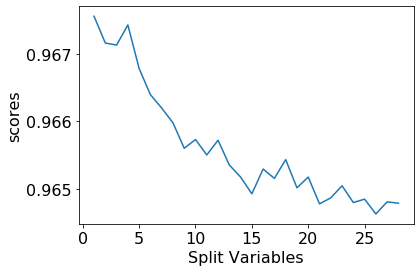

In [69]:
sns.lineplot(x = "Split Variables", y = "scores", (data)=pd.DataFrame(results, columns=['Split Variables', 'scores']))

opt_features = pd.DataFrame(results, columns=['Split Variables', 'scores'])

In [70]:
opt = opt_features[opt_features.scores == np.max(opt_features.scores)]['Split Variables'].values
opt

array([1], dtype=int64)

In [71]:
regr   = RandomForestClassifier(max_features=opt, random_state=0, n_estimators=100)
kfold = KFold(n_splits=10, random_state=42, shuffle=True)
scores = cross_val_score(regr, X_train_norm, y_train, cv = kfold)

In [72]:
np.mean(scores)

0.9629896879002338

In [73]:
kfold = KFold(n_splits=10, random_state=42, shuffle=True)
scores = cross_val_score(regr, scaler.transform(data_dette.drop(['endette'], axis=1)), data_dette['endette'], cv = kfold)

In [74]:
scores

array([0.96582014, 0.96555124, 0.96378847, 0.96462504, 0.96620854,
       0.96402641, 0.96626729, 0.96534106, 0.96540082, 0.96528131])

In [75]:
scores_rf = scores

In [76]:
regr.fit(scaler.transform(X_train.fillna(0)), y_train)
y_hat = regr.predict(scaler.transform(X_test.fillna(0)))
acc_rf = accuracy_score(y_hat, y_test)

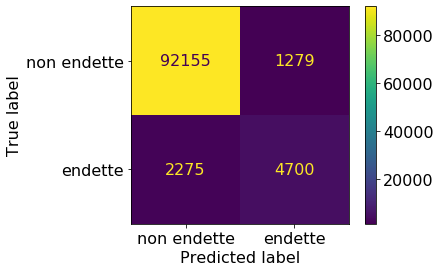

In [118]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(regr, scaler.transform(X_test.fillna(0)), y_test, display_labels = ["non endette", "endette"]) 
plt.show()

In [77]:
acc_rf

0.9646047665049946

In [78]:
regr.feature_importances_

array([0.0826607 , 0.01079245, 0.14845392, 0.03132247, 0.04592473,
       0.13099536, 0.00402874, 0.00591658, 0.0052572 , 0.00214818,
       0.00659999, 0.01400378, 0.00445687, 0.01451368, 0.00177525,
       0.00162737, 0.02099608, 0.00396212, 0.00342132, 0.00457717,
       0.00512095, 0.03100519, 0.00559422, 0.08704606, 0.06281811,
       0.01301816, 0.00044924, 0.00680723, 0.24470687])

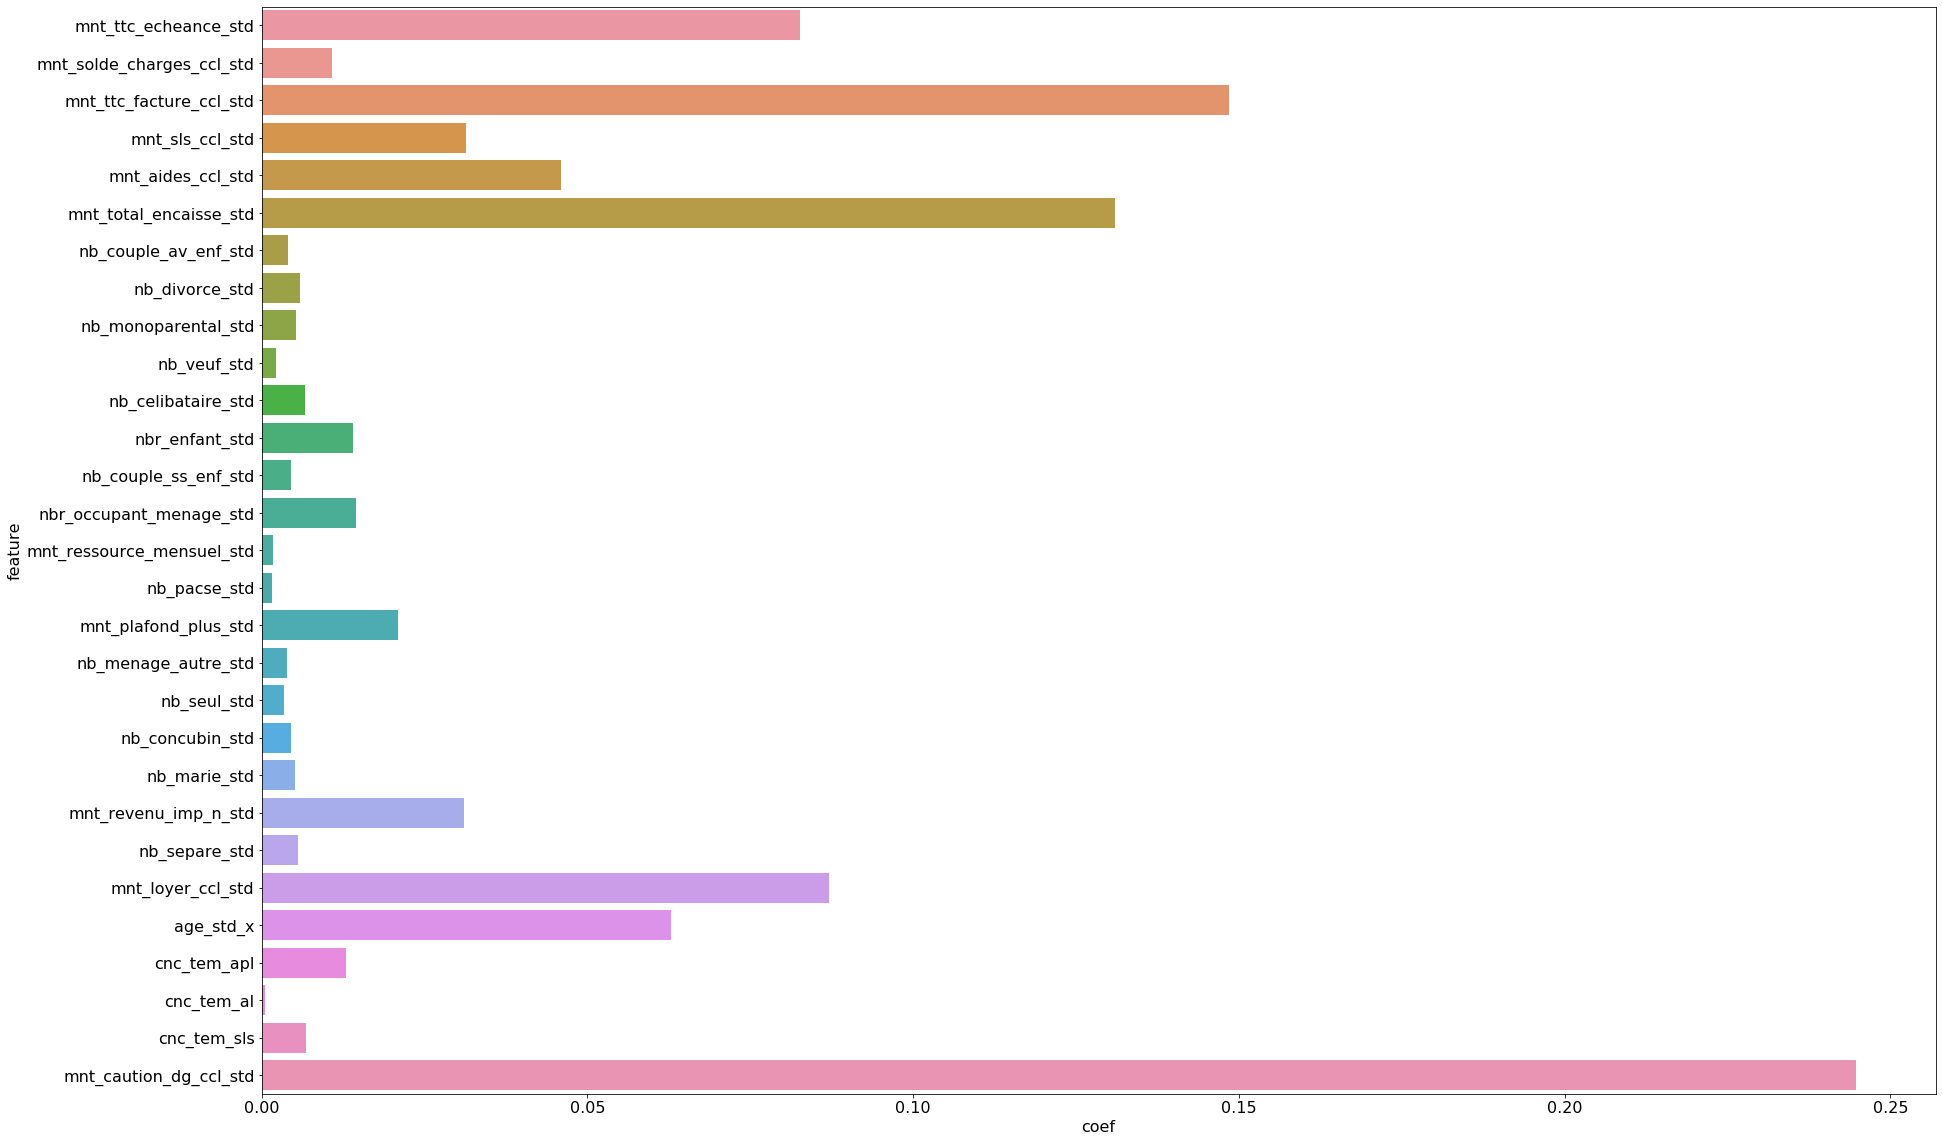

In [127]:
figure = plt.figure(figsize = (30, 20))
sns.barplot(x = "coef", y = "feature", data=pd.DataFrame({"feature" : X_test.columns.tolist(), "coef" : regr.feature_importances_}));

In [129]:
## intervale de confiant
mean = np.mean(scores_rf)
conf_int = np.std(scores_rf) *2
conf_intervale = [mean-conf_int, mean+conf_int]
conf_intervale

[0.9636283168928558, 0.9668337465483766]

In [79]:
compare = pd.DataFrame({"lasso" : scores_lasso, "ridge": scores_ridge, "randomforest": scores_rf})

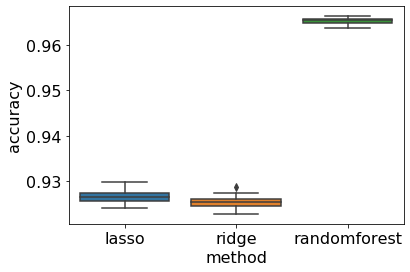

In [80]:
sns.boxplot(x="method", y="accuracy", data=pd.melt(compare).rename(columns={"variable":"method", "value":"accuracy"}));

### SVM

In [87]:
from sklearn.svm import SVC

In [88]:
CC = [0.001, 0.01, 0.1, 1, 10, 100]

In [89]:
SVC_linear = SVC(kernel = "linear", C = 0.001)
kfold = KFold(n_splits=10, random_state=42, shuffle=True)
scores_SVM = cross_val_score(SVC_linear, scaler.transform(data_dette.drop(['endette'], axis=1)), data_dette['endette'], cv = kfold)

In [90]:
SVC_linear = SVC(kernel = "linear", C = 0.001)
SVC_linear.fit(X_train_norm, y_train)
y_hat = SVC_linear.predict(X_test_norm)
acc_SVM = accuracy_score(y_hat, y_test)

### KNN


In [91]:
compare = pd.DataFrame({"lasso" : scores_lasso, "ridge": scores_ridge, "randomforest": scores_rf, "SVC" : scores_SVM})

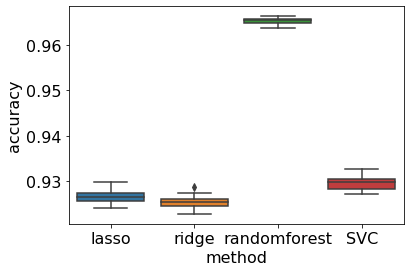

In [92]:
sns.boxplot(x="method", y="accuracy", data=pd.melt(compare).rename(columns={"variable":"method", "value":"accuracy"}));

In [96]:
from sklearn.neighbors import KNeighborsClassifier
results = []
   
neigh = KNeighborsClassifier(n_neighbors=100)
neigh.fit(X_train_norm, y_train)
y_hat = neigh.predict(X_test_norm)
scores = accuracy_score(y_hat, y_test)
results += [[k, np.mean(scores)]]


In [99]:
neigh   = KNeighborsClassifier(n_neighbors=100)
kfold = KFold(n_splits=10, random_state=42, shuffle=True)
scores_KNN = cross_val_score(neigh, scaler.transform(data_dette.drop(['endette'], axis=1)), data_dette['endette'], cv = kfold)

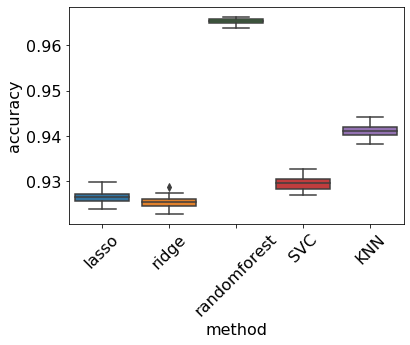

In [106]:
compare = pd.DataFrame({"lasso" : scores_lasso, "ridge": scores_ridge, "randomforest": scores_rf, "SVC" : scores_SVM, "KNN": scores_KNN})
sns.boxplot(x="method", y="accuracy", data=pd.melt(compare).rename(columns={"variable":"method", "value":"accuracy"}))
plt.xticks(rotation=45);


> A partir de la figure dessus, on peut voir la méthode randomforest donne la plus grande précision (0.96) avec une intervale de confiant [0.9636283168928558, 0.9668337465483766]. On va donc choisir randomforest comme notre modèle.

## Probabilité

> Comme nous avons déterminé dessus, les périodes endettement serait janvier-2018, avril-2018, de avril à septembre 2019. On va appliquer randomforest pour prédire la probabilité d'une personne qui sera endettée dans ces périodes. 

In [133]:
data = pd.read_csv('Axe 1/output/clients_manages_tabular_time_series_v3.csv')

pred = None
new_data = None
for date_count in pd.unique(data.date) :
    tdate = data[data.date == date_count].sort_values(by=['id_client']).reset_index()
    if pred == None :
        new_data = tdate
        new_data["endette"] = new_data["solde_std"] > new_data["mnt_ttc_echeance_std"]/2
        new_data = new_data[["id_client", "date", "endette"]]
    else :
        tpred = data[data.date == pred].sort_values(by=['id_client']).reset_index()
        tpred = tpred.rename(columns = {"solde_std": "solde_std_pred", "mnt_ttc_echeance_std": "mnt_ttc_echeance_std_pred"})[["solde_std_pred", "mnt_ttc_echeance_std_pred"]]
        buf_data = pd.concat([tdate, tpred], axis = 1)
        buf_data["endette"] = (buf_data['solde_std'] > buf_data['mnt_ttc_echeance_std']/2) & \
                              (buf_data['solde_std_pred'] > buf_data['mnt_ttc_echeance_std_pred']/2)
        buf_data = buf_data[["id_client", "date", "endette"]]
        new_data = pd.concat([new_data, buf_data], axis = 0)
    pred = date_count

new_data = new_data.sort_values(by=["id_client", "date"])
data = data.merge(new_data, on=["id_client", "date"])
data["endette"] = data["endette"].apply(lambda x : 1 if x else 0)

In [144]:
def data_prepare(date) :
    df = data[data.date==date]
    df = df[df.columns.drop(cols_drop + ["solde_std"]).tolist() + ["endette"]].reset_index(drop=True)
    scale_data = pd.DataFrame(scaler.transform(df.drop("endette", axis = 1)), columns = df.drop("endette", axis = 1).columns)
    return pd.concat([scale_data, df["endette"].reset_index(drop=True)], axis = 1)

In [165]:
jan_2018 = data_prepare(20180131)
avril_2018 = data_prepare(20180430)
avril_2019 = data_prepare(20190430)
may_2019 = data_prepare(20190531)
june_2019 = data_prepare(20190630)
juliet_2019 = data_prepare(20190731)
august_2019 = data_prepare(20190831)
september_2019 = data_prepare(20190930)

In [176]:
def probabilite(data) :
    y_hat = regr.predict(data.drop("endette", axis = 1))
    plot_confusion_matrix(regr, data.drop("endette", axis = 1), data["endette"], display_labels = ["non endette", "endette"]) 
    plt.show()
    pourcentage = sum(y_hat == 1)/len(y_hat)
    conf = [pourcentage * 100 / x for x in conf_intervale[-2:]]
    return conf

### january 2018

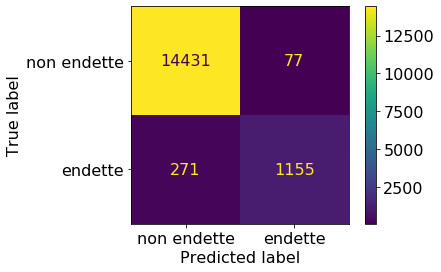

In [177]:
jan_2018_conf = probabilite(jan_2018)

In [178]:
print(jan_2018_conf)

[7.997128865860334, 8.023730651607256]


### avril 2018


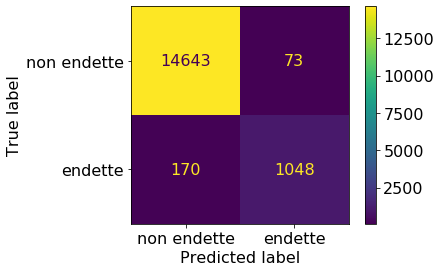

In [179]:
avril_2018_conf = probabilite(avril_2018)

In [180]:
print(avril_2018_conf)

[7.276608326809606, 7.300813360756277]


### avril 2019

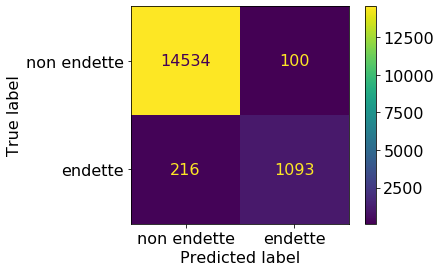

In [183]:
avril_2019_conf = probabilite(avril_2019)

In [182]:
print(avril_2019_conf)

[7.739601442298392, 7.765346584434781]


### May 2019

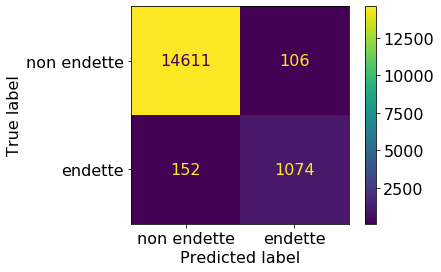

In [184]:
may_2019_conf = probabilite(may_2019)

In [185]:
print(may_2019_conf)

[7.65526379037058, 7.680728390304309]


### june 2019

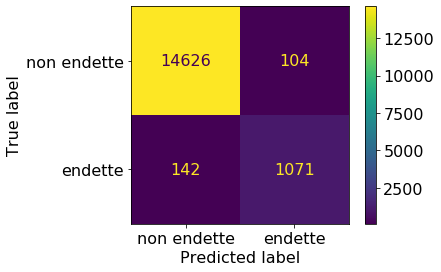

In [186]:
june_2019_conf = probabilite(june_2019)

In [187]:
print(june_2019_conf)

[7.6228262319368065, 7.648182931023358]


### juliet 2019

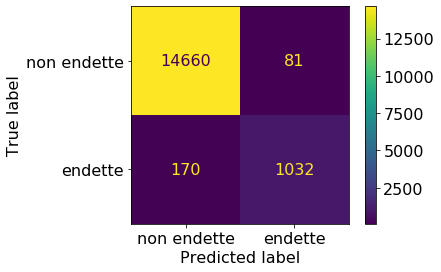

In [189]:
juliet_2019_conf = probabilite(juliet_2019)

In [188]:
print(juliet_2019_conf)

[7.220600507358014, 7.244619235939573]


### August 2019

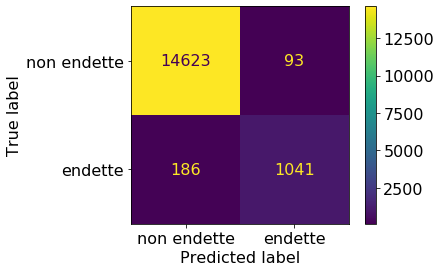

In [190]:
august_2019_conf = probabilite(august_2019)

In [191]:
print(august_2019_conf)

[7.356838252779862, 7.381310164919564]


### Septembre 2019

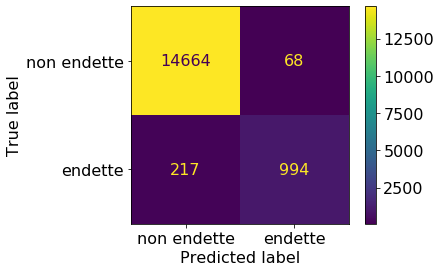

In [192]:
september_2019_conf = probabilite(september_2019)

In [194]:
print(september_2019_conf)

[6.889737411333521, 6.912655551273877]
